In [57]:
!pip install torchinfo

Import Libraries

In [58]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [59]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


Configuration

In [60]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


Seed Value

In [61]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Loading Dataset

In [62]:
data_dir = "/kaggle/input/cse475-project/train"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Benign, Count: 6289
Class: Malignant, Count: 5590


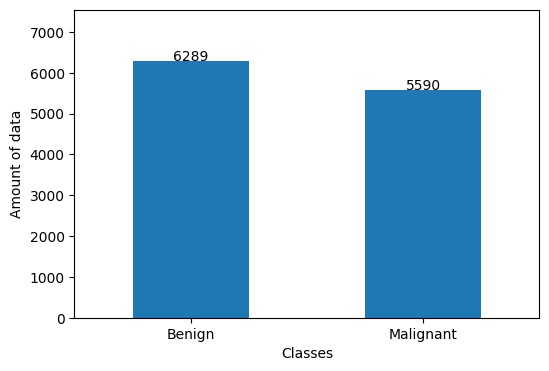

In [63]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

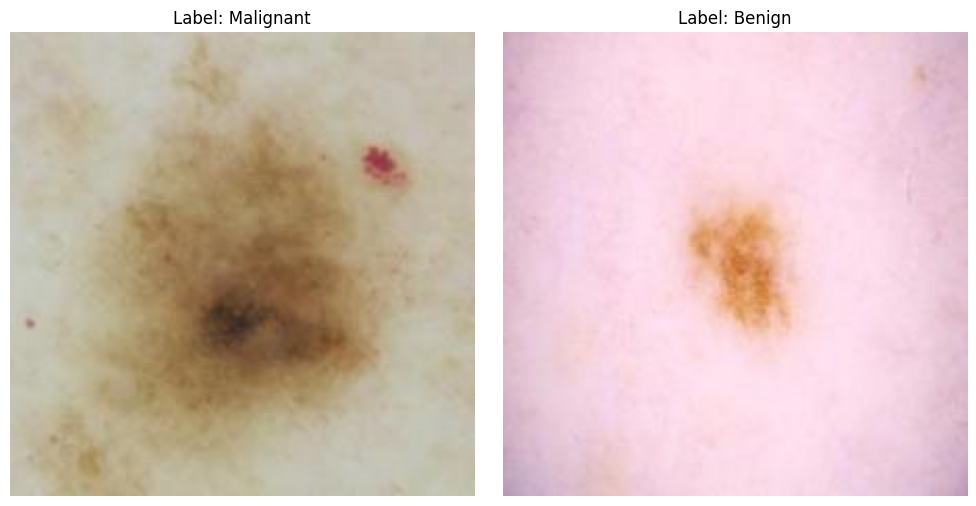

In [64]:
import random
from PIL import Image
import matplotlib.pyplot as plt

classes = df['label'].unique()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for idx, class_label in enumerate(classes):

    class_df = df[df['label'] == class_label]

    random_index = random.randint(0, len(class_df) - 1)
    random_row = class_df.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    axes[idx].imshow(image)
    axes[idx].set_title(f"Label: {label}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


Train-Test-Validation Split (Ratio 70:15:15)

In [65]:
from sklearn.model_selection import train_test_split


train_dataframe, valid_dataframe = train_test_split(
    df,
    test_size=0.30, 
    stratify=df['label'],
    random_state=42
)


total = len(df)
train_ratio = len(train_dataframe) / total
valid_ratio = len(valid_dataframe) / total


print(f"Train: {len(train_dataframe)} ({train_ratio:.2%})")
print(f"Validation: {len(valid_dataframe)} ({valid_ratio:.2%})")
print(f"Total: {total}")


Train: 8315 (70.00%)
Validation: 3564 (30.00%)
Total: 11879


In [66]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("-------------------------------------------")
print("Total amount of data in the dataset: ", len(df))


Training Data:  8315
Validation Data:  3564
-------------------------------------------
Total amount of data in the dataset:  11879


In [67]:
from tabulate import tabulate


class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()


train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]


print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))


Train Dataset
Class        Count
---------  -------
Benign        4402
Malignant     3913

Validation Dataset
Class        Count
---------  -------
Benign        1887
Malignant     1677


Device Variable

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Checkpoint


In [69]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)


Dataset Class, Dataloader and Transform

In [70]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Benign': 0, 'Malignant': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [71]:
from torch.utils.data import DataLoader
from torchvision import transforms

train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset(
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset

dataloader_train_dataset, dataloader_valid_dataset = data_transfrom()


Neural Network (ResNet)

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_class = 2
learning_rate = 0.0001
train_batch = 16  # example batch size

# Load pretrained model
weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights)

# Replace the classifier layer
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, total_class)

# Move model to device
model = model.to(device)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Model summary
summary(model, input_size=(3, 224, 224), batch_size=train_batch)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 96, 56, 56]           4,704
       LayerNorm2d-2           [16, 96, 56, 56]             192
            Conv2d-3           [16, 96, 56, 56]           4,800
           Permute-4           [16, 56, 56, 96]               0
         LayerNorm-5           [16, 56, 56, 96]             192
            Linear-6          [16, 56, 56, 384]          37,248
              GELU-7          [16, 56, 56, 384]               0
            Linear-8           [16, 56, 56, 96]          36,960
           Permute-9           [16, 96, 56, 56]               0
  StochasticDepth-10           [16, 96, 56, 56]               0
          CNBlock-11           [16, 96, 56, 56]               0
           Conv2d-12           [16, 96, 56, 56]           4,800
          Permute-13           [16, 56, 56, 96]               0
        LayerNorm-14           [16, 56,

In [73]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=50, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/50: 100%|██████████| 260/260 [03:18<00:00,  1.31it/s, acc=0.872, loss=0.291]

Training Loss: 0.291 Acc: 0.872


Validation Loss: 0.240 Acc: 0.907
Best model saved at epoch 1 with validation accuracy: 0.907


Epoch 2/50: 100%|██████████| 260/260 [03:18<00:00,  1.31it/s, acc=0.921, loss=0.193]

Training Loss: 0.193 Acc: 0.921


Validation Loss: 0.194 Acc: 0.923
Best model saved at epoch 2 with validation accuracy: 0.923


Epoch 3/50: 100%|██████████| 260/260 [03:18<00:00,  1.31it/s, acc=0.955, loss=0.118]

Training Loss: 0.118 Acc: 0.955


Validation Loss: 0.216 Acc: 0.915


Epoch 4/50: 100%|██████████| 260/260 [03:19<00:00,  1.31it/s, acc=0.974, loss=0.0694]

Training Loss: 0.069 Acc: 0.974


Validation Loss: 0.277 Acc: 0.910


Epoch 5/50: 100%|██████████| 260/260 [03:18<00:00,  1.31it/s, acc=0.981, loss=0.0514]

Training Loss: 0.051 Acc: 0.981


Validation Loss: 0.382 Acc: 0.891


Epoch 6/50: 100%|██████████| 260/260 [03:19<00:00,  1.30it/s, acc=0.985, loss=0.0366]

Training Loss: 0.037 Acc: 0.985


Validation Loss: 0.307 Acc: 0.916
Early stopping criteria met. No improvement in validation accuracy or validation loss for 5 consecutive epochs. Training stopped.
Training Time: 1267.25 seconds ---> 21.12 minutes


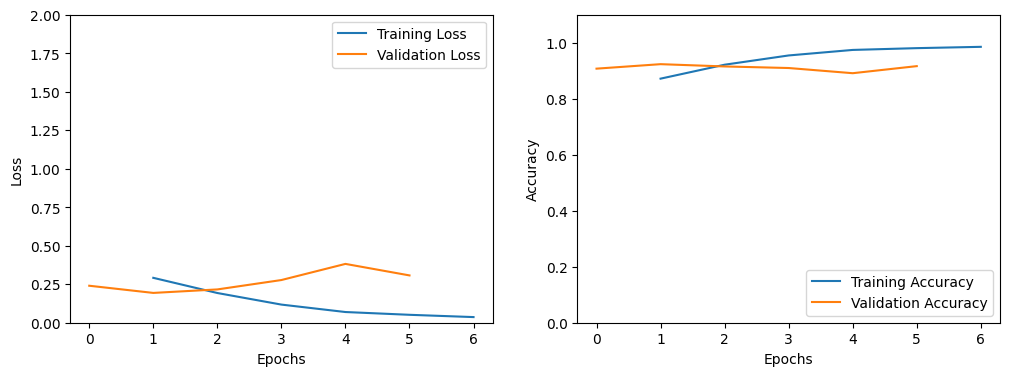

In [74]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

In [75]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

Evaluation

In [76]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 2) - Validation Loss: 0.194, Validation Accuracy: 0.923


In [77]:
from sklearn.metrics import classification_report
import numpy as np
import torch

def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy

def evaluate_model(model, dataloader, num_classes, dataset_name="Dataset"):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    class_names = [str(i) for i in range(num_classes)]

    print(f"\n=== {dataset_name} Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    class_acc = class_accuracy(model, dataloader, num_classes)
    for i in range(num_classes):
        print(f"{dataset_name} - Class {i} Accuracy: {class_acc[i]:.3f}")

# Run evaluation for both train and validation
evaluate_model(model, dataloader_train_dataset, 2, dataset_name="Train")
evaluate_model(model, dataloader_valid_dataset, 2, dataset_name="Validation")



=== Train Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4402
           1       0.98      0.96      0.97      3913

    accuracy                           0.97      8315
   macro avg       0.97      0.97      0.97      8315
weighted avg       0.97      0.97      0.97      8315

Train - Class 0 Accuracy: 0.978
Train - Class 1 Accuracy: 0.959

=== Validation Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1887
           1       0.92      0.92      0.92      1677

    accuracy                           0.92      3564
   macro avg       0.92      0.92      0.92      3564
weighted avg       0.92      0.92      0.92      3564

Validation - Class 0 Accuracy: 0.931
Validation - Class 1 Accuracy: 0.915


In [78]:
data_dir1 = "/kaggle/input/cse475-project/test"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df1 = pd.DataFrame({"file_path": file_paths, "label": labels})
df1 = df1.sample(frac=1).reset_index(drop=True)

Class: Benign, Count: 6289
Class: Malignant, Count: 5590


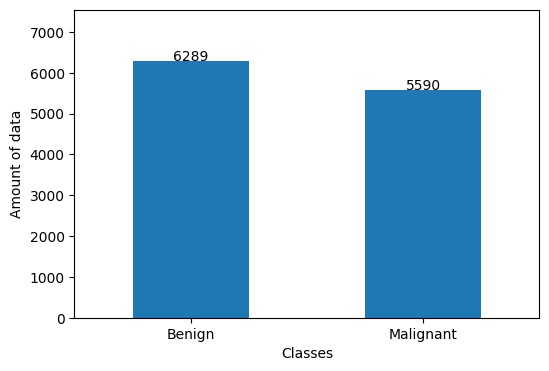

In [79]:
class_counts_train = df1['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

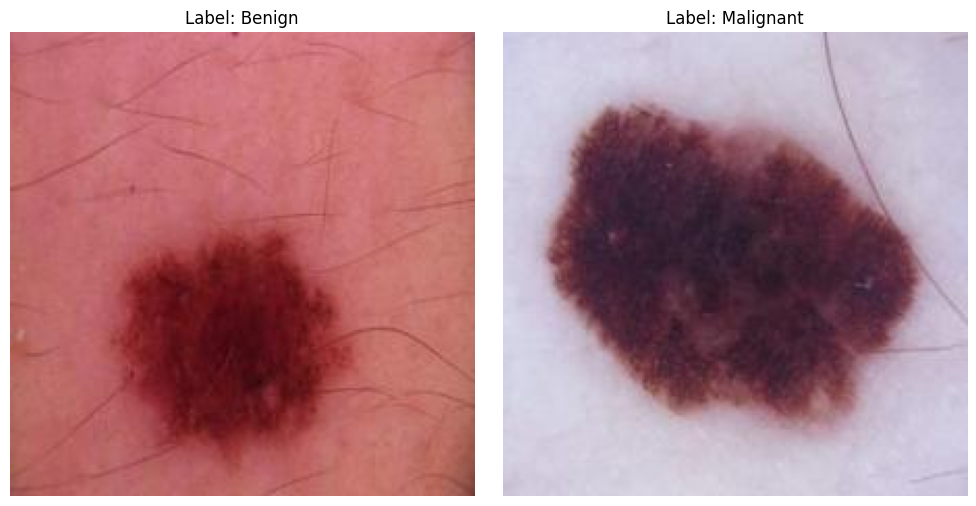

In [80]:
import random
from PIL import Image
import matplotlib.pyplot as plt

classes = df1['label'].unique()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for idx, class_label in enumerate(classes):

    class_df1 = df1[df1['label'] == class_label]

    random_index = random.randint(0, len(class_df1) - 1)
    random_row = class_df1.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    axes[idx].imshow(image)
    axes[idx].set_title(f"Label: {label}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [81]:
from sklearn.model_selection import train_test_split


rest_dataframe, test_df1 = train_test_split(
    df1,
    test_size=0.30,
    stratify=df1['label'],
    random_state=42
)

print("Remaining Data (for training/validation):", len(rest_dataframe))
print("Test Data:", len(test_df1))
print("-------------------------------------------")
print("Total data in dataset:", len(df1))


Remaining Data (for training/validation): 8315
Test Data: 3564
-------------------------------------------
Total data in dataset: 11879


In [82]:
print("Test Data: ", len(test_df1))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df1))


Test Data:  3564
-------------------------------------------
Total amounts of data in the dataset:  11879


In [83]:
from tabulate import tabulate
class_counts_test = test_df1['label'].value_counts()
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Test Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))


Test Dataset
Class        Count
---------  -------
Benign        1887
Malignant     1677


In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [86]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Benign': 0, 'Malignant': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [87]:
from torch.utils.data import DataLoader
from torchvision import transforms

test_batch = 8  

def data_transform_test_only():
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    test_dataset = ImageDataset(
        test_df1,
        normalize,
        is_lb=True
    )

    dataloader_test_dataset = DataLoader(
        test_dataset, 
        batch_size=test_batch, 
        shuffle=False, 
        num_workers=2
    )

    return dataloader_test_dataset

dataloader_test_dataset = data_transform_test_only()


In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_class = 2
learning_rate = 0.0001
test_batch = 16  # or whatever your batch size is

# Load pretrained ConvNeXt model correctly
weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights)

# Modify the classifier for your task (2 classes)
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, total_class)

# Move to GPU/CPU
model = model.to(device)

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Print model summary
summary(model, input_size=(3, 224, 224), batch_size=test_batch)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 96, 56, 56]           4,704
       LayerNorm2d-2           [16, 96, 56, 56]             192
            Conv2d-3           [16, 96, 56, 56]           4,800
           Permute-4           [16, 56, 56, 96]               0
         LayerNorm-5           [16, 56, 56, 96]             192
            Linear-6          [16, 56, 56, 384]          37,248
              GELU-7          [16, 56, 56, 384]               0
            Linear-8           [16, 56, 56, 96]          36,960
           Permute-9           [16, 96, 56, 56]               0
  StochasticDepth-10           [16, 96, 56, 56]               0
          CNBlock-11           [16, 96, 56, 56]               0
           Conv2d-12           [16, 96, 56, 56]           4,800
          Permute-13           [16, 56, 56, 96]               0
        LayerNorm-14           [16, 56,

In [89]:
# ------------------ TEST EVALUATION ------------------

model.eval()
correct_test = 0
total_test = 0
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = test_loss / total_test
test_accuracy = correct_test / total_test

print(f"\nTest Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

# Optionally, add to Excel sheet
test_summary = pd.DataFrame({
    "Metric": ["Test Loss", "Test Accuracy"],
    "Value": [avg_test_loss, test_accuracy]
})

# Save both training history and test results
with pd.ExcelWriter('/kaggle/working/training_data_with_test.xlsx') as writer:
    history.to_excel(writer, index=False, sheet_name='Train_Val_History')
    test_summary.to_excel(writer, index=False, sheet_name='Test_Summary')



Test Loss: 0.626
Test Accuracy: 0.683


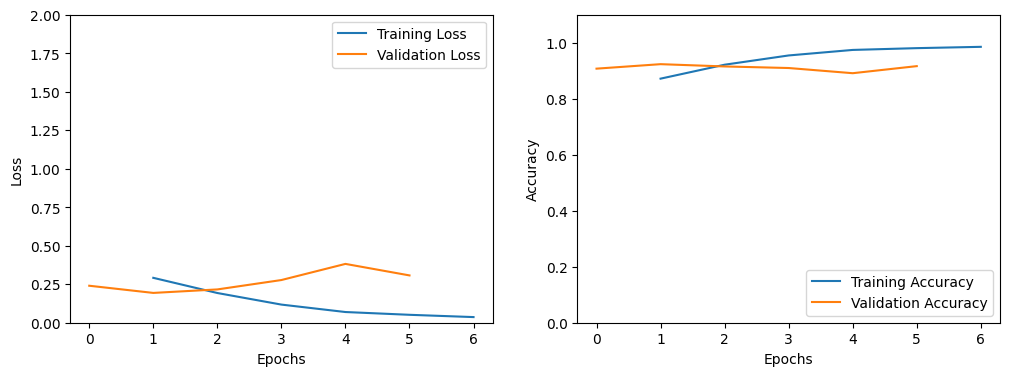

In [90]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

In [91]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [92]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 2) - Validation Loss: 0.194, Validation Accuracy: 0.923


In [93]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1887
           1       0.95      0.95      0.95      1677

    accuracy                           0.95      3564
   macro avg       0.95      0.95      0.95      3564
weighted avg       0.95      0.95      0.95      3564

Class 0 Accuracy: 0.959
Class 1 Accuracy: 0.948
